In [1]:
# Import libraries
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.display.max_columns = None

In [2]:
# Read metadata and merge pre_biopsy data
metadata=pd.read_csv('data/metadata_update.tsv',sep="\t", header=0)
pre_biopsy=pd.read_csv('data/pre_biopsy_drugs_update.tsv',sep="\t", header=0)
metadata['patientIdentifier'] = metadata['sampleId'].str[:12]
df_survival=pd.merge(pre_biopsy, metadata, on='patientIdentifier')
df_survival=df_survival[df_survival['biopsyDate'].isnull()==False] #delete all that dont have a given biopsyDate
df_survival=df_survival[['sampleId','hasSystemicPreTreatment','hasRadiotherapyPreTreatment','biopsySite', 'startDate','biopsyDate','birthYear','consolidatedTreatmentType','primaryTumorLocation','gender','type','deathDate', 'primaryTumorSubType','tumorPurity', 'treatmentEndDate']]
df_survival['status'] = 1 # set status as dead
df_survival['deathDate'] = df_survival['deathDate'].fillna(0) # If donor is still alive
df_survival['status'][df_survival['deathDate']==0] = 0 # set alive donors as alive

# Calculating survival times
'''
Assumption: If there is not death reported, we will asume that the donor is still alive at the date of the last update of the metadata.
'''

df_survival['biopsyDate'] = pd.to_datetime(df_survival['biopsyDate'])

## OS (Overall Survival): Death date - Biopsy date
### Dead donors
df_survival['deathDate'] = pd.to_datetime(df_survival['deathDate'])
mask = df_survival['status']==1
df_survival.loc[mask, 'OS_time'] = (df_survival['deathDate'] - df_survival['biopsyDate']).dt.days
### Alive donors
last_update = pd.to_datetime('2023-04-04') # If there is not deathDate, I substract it by the last documented update
mask = pd.notnull(df_survival['startDate']) & (df_survival['status'] == 0) 
df_survival.loc[mask, 'OS_time'] = (last_update - df_survival['biopsyDate']).dt.days

df_survival = df_survival[df_survival['OS_time']>0.0]

## PFI (Progression-free interval): treatmentEndDate - Biopsy date
## If treatment ended
df_survival['treatmentEndDate'] = pd.to_datetime(df_survival['treatmentEndDate'])
mask = pd.notnull(df_survival['treatmentEndDate'])
df_survival.loc[mask, 'PFI_time'] = (df_survival['treatmentEndDate'] - df_survival['biopsyDate']).dt.days
### If treatment is still ongoing
mask = pd.isnull(df_survival['treatmentEndDate'])
df_survival.loc[mask, 'PFI_time'] = (last_update - df_survival['biopsyDate']).dt.days

df_survival = df_survival[df_survival['PFI_time']>0]

df_survival = df_survival.drop_duplicates(subset='sampleId', keep="first")
df_survival

/tmp/ipykernel_20271/196717585.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survival['status'][df_survival['deathDate']==0] = 0 # set alive donors as alive


,sampleId,hasSystemicPreTreatment,hasRadiotherapyPreTreatment,biopsySite,startDate,biopsyDate,birthYear,consolidatedTreatmentType,primaryTumorLocation,gender,type,deathDate,primaryTumorSubType,tumorPurity,treatmentEndDate,status,OS_time,PFI_time
0,CPCT02010003T,Yes,Yes,Liver,2009-12-14,2012-04-18,1955.0,Chemotherapy,Breast,female,Hormonal therapy,2013-01-29,ER-positive/HER2-negative,0.40,2012-10-01,1,286.0,166.0
4,CPCT02010022T,Yes,Yes,Liver,2011-04-01,2012-07-10,1952.0,Chemotherapy,Lung,male,Chemotherapy,2014-04-14,Non-small cell carcinoma,0.45,2012-11-26,1,643.0,139.0
6,CPCT02010037T,Yes,Yes,Skin,2012-06-01,2012-08-06,1958.0,Chemotherapy,Lung,male,Chemotherapy,2012-12-06,Non-small cell carcinoma,0.56,2012-08-29,1,122.0,23.0
8,CPCT02010050T,Yes,No,Lung,2011-12-20,2012-09-17,1946.0,Chemotherapy,Lung,female,Chemotherapy,2013-01-21,Non-small cell carcinoma,0.37,2012-11-07,1,126.0,51.0
11,CPCT02010063T,Yes,Yes,Left mamma,2010-04-30,2012-10-26,1974.0,Multiple therapy,Lung,female,Chemotherapy,2015-03-14,Non-small cell carcinoma,0.91,2012-12-11,1,869.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10014,CPCT02460004T,Yes,No,Liver,2016-02-11,2018-11-01,1966.0,Multiple therapy,Breast,female,Targeted therapy,1970-01-01,ER-positive/HER2-positive,0.54,NaT,0,1615.0,1615.0
10018,CPCT02460005T,Yes,Yes,Liver,2017-07-31,2019-01-02,1988.0,Chemotherapy,Breast,female,Chemotherapy,2019-06-04,Triple negative,0.92,2019-05-06,1,153.0,124.0
10021,CPCT02460006T,Yes,Yes,Liver,2009-06-01,2019-01-31,1968.0,Chemotherapy,Breast,female,Chemotherapy,2019-03-23,ER-positive/HER2-negative,0.66,2019-03-23,1,51.0,51.0
10034,CPCT02470001T,Yes,Yes,Liver,2014-10-13,2018-12-07,1931.0,NaN,Breast,female,Hormonal therapy,2019-12-26,ER-positive/HER2-negative,0.38,NaT,1,384.0,1579.0


In [7]:
df['pur_diff'] = abs(df['pur'] - df['tumorPurity'])
df.sort_values(by='pur_diff', ascending=False)[0:10]

,sampleId,hasSystemicPreTreatment,hasRadiotherapyPreTreatment,biopsySite,startDate,biopsyDate,birthYear,consolidatedTreatmentType,primaryTumorLocation,gender,type,deathDate,primaryTumorSubType,tumorPurity,treatmentEndDate,status,OS_time,PFI_time,percentage,CN,filename,name,pur,S,C,S_help_pur,S_help_C,C_help_pur,C_help_S,S_help_pur_help_C,C_help_pur_help_S,class,T,pur_diff
212,CPCT02070086T,Yes,No,Peritoneum,2016-07-27,2017-02-09,1942.0,NaN,Mesothelium,female,Chemotherapy,2017-08-02,NaN,0.96,NaT,1,174.0,2245.0,94.948848,2,CPCT02070086T.bed,CPCT02070086T.bed.gz,0.252580,2549.439941,1328.715820,3604.131348,1266.488770,1336.138550,1345.770752,2742.533447,1315.897583,EXP,NaN,0.707420
63,CPCT02020267T,Yes,Yes,Liver,2013-05-22,2016-02-23,1937.0,NaN,Colorectum,male,Chemotherapy,2017-07-01,NaN,1.00,NaT,1,494.0,2597.0,92.683621,2,CPCT02020267T.bed,CPCT02020267T.bed.gz,0.357461,4563.899902,92.809494,4525.527344,4695.051270,90.188316,86.991096,4167.453125,89.602058,EXP,NaN,0.642539
322,CPCT02130103T,Yes,Yes,Lymph node,2018-01-08,2018-04-12,1960.0,Chemotherapy,Unknown,male,Chemotherapy,1970-01-01,NaN,0.59,2018-09-11,0,1818.0,152.0,73.151255,2,CPCT02130103T.bed,CPCT02130103T.bed.gz,1.115584,4040.195801,1194.623291,3208.556152,6846.096191,202.211670,2716.105225,8096.325684,138.208725,WF,NaN,0.525584
263,CPCT02080099T,Yes,Yes,Primary,2016-10-24,2017-04-21,1968.0,NaN,Head and neck,male,Immunotherapy,2017-10-12,NaN,0.55,NaT,1,174.0,2174.0,76.966376,2,CPCT02080099T.bed,CPCT02080099T.bed.gz,1.057528,5432.966309,1159.383179,4597.912109,8890.908203,-40.936104,2195.767090,10342.374023,-177.830811,WF,NaN,0.507528
397,CPCT02340029T,Yes,No,Liver,2016-12-01,2017-10-05,1957.0,Chemotherapy,Colorectum,female,Chemotherapy,2018-02-16,NaN,0.53,2017-11-24,1,134.0,50.0,71.419971,2,CPCT02340029T.bed,CPCT02340029T.bed.gz,1.033899,13175.716797,1580.612549,16179.227539,18691.890625,327.018646,747.154785,14196.679688,156.435852,WF,NaN,0.503899
341,CPCT02160034T,Yes,Yes,Lymph node,2016-07-25,2017-10-20,1961.0,Multiple therapy,Colorectum,female,Chemotherapy,1970-01-01,NaN,0.56,2018-09-05,0,1992.0,320.0,76.200792,2,CPCT02160034T.bed,CPCT02160034T.bed.gz,1.061197,6148.905762,2057.949707,7097.075684,10165.074219,338.705139,1555.921631,6286.443848,108.166756,WF,NaN,0.501197
161,CPCT02050141T,Yes,No,Lymph node,2015-06-01,2017-03-21,1948.0,Immunotherapy,Skin,male,Immunotherapy,1970-01-01,NaN,0.55,2017-11-17,0,2205.0,241.0,74.726318,2,CPCT02050141T.bed,CPCT02050141T.bed.gz,1.045727,18161.953125,2281.220459,14642.970703,27750.744141,317.910278,686.145081,18530.933594,42.361786,WF,NaN,0.495727
357,CPCT02220044T,Yes,Yes,Liver,2009-11-05,2018-03-12,1947.0,Chemotherapy,Breast,female,Hormonal therapy,2019-02-09,ER-positive/HER2-negative,0.56,2018-12-06,1,334.0,269.0,84.660667,2,CPCT02220044T.bed,CPCT02220044T.bed.gz,1.055494,13907.575195,2737.524902,12254.692383,15325.276367,167.153305,3162.137207,11724.863281,-69.711327,WF,NaN,0.495494
413,CPCT02440004T,Yes,No,Liver,2011-07-07,2017-12-19,1941.0,NaN,Colorectum,female,Chemotherapy,2018-01-30,NaN,0.55,NaT,1,42.0,1932.0,79.504922,2,CPCT02440004T.bed,CPCT02440004T.bed.gz,1.033389,9157.588867,3155.619873,9037.961914,8269.031250,262.906464,2349.078369,8772.106445,62.203072,WF,NaN,0.483389
36,CPCT02010731T,Yes,Yes,subcutaneous,2008-07-01,2017-12-22,1963.0,Chemotherapy,Breast,female,Chemotherapy,1970-01-01,ER-positive/HER2-negative,0.49,2018-09-06,0,1929.0,258.0,81.105708,2,CPCT02010731T.bed,CPCT02010731T.bed.gz,0.973184,45402.121094,1434.729370,50940.808594,45584.964844,1268.322510,1084.886353,44934.441406,195.993546,WF,NaN,0.483184


In [20]:
# Format the data
# Merge the prediction
df = pd.merge(df_survival, df_class, on='sampleId')
# Remove NA's
df = df.dropna(subset=['birthYear', 'gender', 'OS_time', 'PFI_time'])
# class: WF -> 0, EXP -> 1
df = df[df['class']!='CC']
df['class'] = df['class'].replace(to_replace='WF', value=0)
df['class'] = df['class'].replace(to_replace='EXP', value=1)
# Calculate age at diagnosis based on birthYear
df['year_of_diagnosis']=df['biopsyDate'].astype(str)
df['year_of_diagnosis'] = df['year_of_diagnosis'].str[:4]
df['year_of_diagnosis']=df['year_of_diagnosis'].astype(int)
df['birthYear']=df['birthYear'].astype(int)
df['age'] = (df['year_of_diagnosis']-df['birthYear']) # change to biopsy date. 
df['age']=df['age'].astype(int)
# # gender: female -> 0, male -> 1
df['gender'] = df['gender'].replace(to_replace='female', value=0)
df['gender'] = df['gender'].replace(to_replace='male', value=1)
# # Add vital state
# df['type'] = df['primaryTumorLocation'] + df['primaryTumorSubType']
# Filter by cancer type
# df = df[df['primaryTumorLocation']=='Stomach']
# print(pd.crosstab(index=df['class'], columns=df['type']))
df = df[df['consolidatedTreatmentType']=='Immunotherapy']

df

,sampleId,hasSystemicPreTreatment,hasRadiotherapyPreTreatment,biopsySite,startDate,biopsyDate,birthYear,consolidatedTreatmentType,primaryTumorLocation,gender,type,deathDate,primaryTumorSubType,tumorPurity,treatmentEndDate,status,OS_time,PFI_time,name,class,year_of_diagnosis,age
19,CPCT02010263T,Yes,Yes,Adrenal gland,2015-01-12,2015-10-16,1967,Immunotherapy,Lung,0,Chemotherapy,2016-12-14,Non-small cell carcinoma,0.20,2016-02-25,1,425.0,132.0,CPCT02010263T.bed.gz,0,2015,48
24,CPCT02010272T,Yes,Yes,Lung,2014-12-01,2015-12-11,1942,Immunotherapy,Lung,1,Chemotherapy,1970-01-01,Non-small cell carcinoma,0.41,2017-01-31,0,2671.0,417.0,CPCT02010272T.bed.gz,0,2015,73
38,CPCT02010333TII,Yes,No,Lymph node,2015-11-13,2016-10-28,1968,Immunotherapy,Lung,0,Chemotherapy,2016-12-27,Non-small cell carcinoma,0.55,2016-12-22,1,60.0,55.0,CPCT02010333TII.bed.gz,0,2016,48
46,CPCT02010356T,Yes,Yes,subcutaneous,2016-01-01,2016-05-24,1960,Immunotherapy,Lung,1,Chemotherapy,1970-01-01,Non-small cell carcinoma,0.54,2017-06-30,0,2506.0,402.0,CPCT02010356T.bed.gz,0,2016,56
49,CPCT02010373T,Yes,No,pleural lesion,2015-11-01,2016-06-30,1957,Immunotherapy,Lung,1,Chemotherapy,1970-01-01,Non-small cell carcinoma,0.67,2018-07-13,0,2469.0,743.0,CPCT02010373T.bed.gz,0,2016,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882,CPCT02270049T,Yes,Yes,Bone,2018-01-11,2019-06-06,1947,Immunotherapy,Lung,1,Chemotherapy,2020-02-05,Non-small cell carcinoma,0.37,2019-10-22,1,244.0,138.0,CPCT02270049T.bed.gz,0,2019,72
1887,CPCT02290020T,Yes,No,Liver,2016-07-26,2017-10-16,1963,Immunotherapy,Urothelial tract,0,Chemotherapy,2017-11-07,NaN,0.46,2017-11-07,1,22.0,22.0,CPCT02290020T.bed.gz,1,2017,54
1982,CPCT02330128T,Yes,Yes,Lymph node,2017-09-10,2018-11-12,1957,Immunotherapy,Head and neck,1,Chemotherapy,2019-01-21,NaN,0.76,2019-01-03,1,70.0,52.0,CPCT02330128T.bed.gz,0,2018,61
2034,CPCT02340107T,Yes,Yes,subcutaneos,2012-05-01,2019-01-17,1947,Immunotherapy,Kidney,1,Targeted therapy,2019-03-30,Renal cell carcinoma,0.28,2019-01-25,1,72.0,8.0,CPCT02340107T.bed.gz,1,2019,72


In [18]:
# Survival analysis: all cancer types
# Reduced data frame with the desired parameters
cox_df = df[['age','gender','OS_time','status', 'class']] 

# Fitting the model and printing the results
cph = CoxPHFitter()
cph.fit(cox_df, duration_col = 'OS_time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 638 total observations, 169 right-censored observations>
             duration col = 'OS_time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 638
number of events observed = 469
   partial log-likelihood = -2782.35
         time fit was run = 2023-04-20 14:23:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
gender      0.10       1.10       0.10            -0.09             0.29                 0.92                 1.33
class      -0.06       0.94       0.10            -0.26             0.14                 0.77                 1.15

            cmp to     z    p   -log2(p)
covariate                               
age           0.00  0.64 0.52       0.93
gender        0.00  1.03 0.30       1.73
class         0.00 -0.61 0.54       0.89
---
Concordance = 0.51
Partial AIC = 5570.69
log-likelihood ratio test = 2.08 on 3 df
-log2(p) of ll-ratio test = 0.85

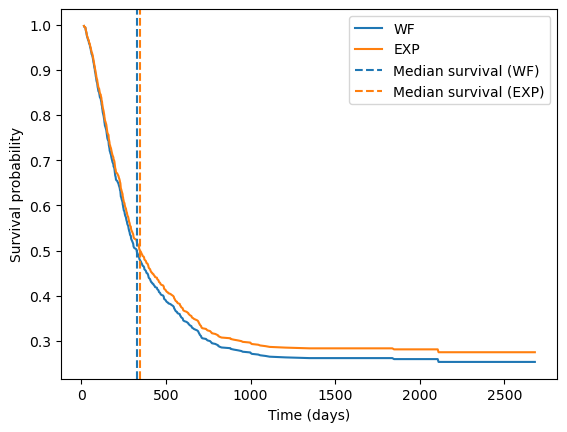

In [19]:
# Plot survival probability
class_wf = cph.predict_survival_function(df[df['class'] == 0]).mean(axis=1)
class_exp = cph.predict_survival_function(df[df['class'] == 1]).mean(axis=1)

# Plot survival probability
plt.plot(class_wf.index, class_wf.values, label='WF')
plt.plot(class_exp.index, class_exp.values, label='EXP')
plt.axvline(median_survival_times(class_wf), linestyle='--', color='tab:blue', label='Median survival (WF)')
plt.axvline(median_survival_times(class_exp), linestyle='--', color='tab:orange', label='Median survival (EXP)')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.legend()
plt.show()

In [40]:
# Hazard ratio
hr = cph.hazard_ratios_['class']
print('Hazard Ratio =',hr)
print('As it is significant and higher than 1, the predictor variable with higher value (EXP:1) has a higher risk of experiencing the event (death) than (WF:0)')

Hazard Ratio = 2.5771340308461594
As it is higher than 1, the predictor variable with higher value (EXP:1) has a higher risk of experiencing the event (death) than (WF:0)
